# Confusion Matrix

In [1]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
        https://stackoverflow.com/a/50386871
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Data Pickling

In [2]:
#Import statements
import pickle
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve

# thanks https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
import datetime, os

In [3]:
# Use tensorboard for visualisations
logdir = os.path.join("tensorboard_logs", "cnn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
def make_tensorboard_callback(logdir):
    '''
    Curries the @arg logdir string into the callback that uses it. 
    This allows the different algorithms to log to different places by calling this function with a unique name string.
    
    Returns a callback suitable for use in a Keras model's `callbacks` field (and so can be initialised in the KerasClassifier wrapper too)
    '''
    dir = os.path.join("tensorboard_logs", logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    return keras.callbacks.TensorBoard(
        log_dir=dir, histogram_freq=1, write_graph=True, write_images=True
    )

In [4]:
with open('../../data/processed/full_set.pkl', 'rb') as f:
    full_set = pickle.load(f)
with open('../../data/processed/train_set.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('../../data/processed/test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('../../data/processed/train_set_30.pkl', 'rb') as f:
    train_set_30 = pickle.load(f)
with open('../../data/processed/test_set_30.pkl', 'rb') as f:
    test_set_30 = pickle.load(f)
with open('../../data/processed/train_set_70.pkl', 'rb') as f:
    train_set_70 = pickle.load(f)
with open('../../data/processed/test_set_70.pkl', 'rb') as f:
    test_set_70 = pickle.load(f)

In [5]:
test_set_70.head()
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,target
5757,70.000000,77.000000,72.000000,72.0,73.0,75.0,76.000000,73.000000,79.000000,77.000000,...,62.000000,61.000000,67.000000,65.000000,62.000000,58.000000,59.000000,61.000000,63.000000,5
7510,30.685511,30.457007,31.228504,31.0,30.0,29.0,29.542993,30.314489,30.857482,30.085985,...,23.914015,25.228504,23.685511,22.914015,22.142518,23.142518,25.457007,25.228504,25.228504,7
55,8.000000,8.000000,10.000000,15.0,27.0,28.0,24.000000,19.000000,13.000000,11.000000,...,13.000000,14.000000,13.000000,13.000000,13.000000,14.000000,12.000000,12.000000,12.000000,0
1983,18.000000,18.000000,19.000000,22.0,25.0,24.0,23.000000,22.000000,22.000000,20.000000,...,13.000000,13.000000,12.000000,12.000000,12.000000,12.000000,12.000000,13.000000,12.000000,1
1842,36.000000,36.000000,35.000000,35.0,34.0,33.0,34.000000,34.000000,34.000000,34.000000,...,144.000000,130.000000,102.000000,75.000000,53.000000,41.000000,42.000000,43.000000,42.000000,1


In [6]:
# Split into X, y format 
X_train = train_set.T.iloc[:-1].T
y_train = train_set.T.iloc[-1].T

X_test = test_set.T.iloc[:-1].T
y_test = test_set.T.iloc[-1].T

In [7]:
y_train.head()

5757    5.0
7510    7.0
55      0.0
1983    1.0
1842    1.0
Name: target, dtype: float64

# Multilayer Perceptron

### Experiment with various Neural Network parameters: add or remove nodes, layers and connections, vary the learning rate, epochs and momentum, and validation threshold.

In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
def get_mlp():
    mlp = MLPClassifier(random_state=42
                        # more non default parameters? E.g. only stochastic gradient descent has been covered in lectures 
                        # also doesn't reach convergence before timeout with current settings
                       )
    return mlp

### Trying it using keras:

In [9]:
from numpy.random import seed
import random
import tensorflow as tf
np.random.seed(42)
random.seed(42)
from tensorflow import keras
# tf.random.set_random_seed(42)
tf.random.set_seed(42)

from keras.wrappers.scikit_learn import KerasClassifier

# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/
from keras.models import Sequential
from keras.layers import Dense

def build_keras_model():
    with tf.name_scope("firstnet"):
        model = Sequential()
        model.add(Dense(1024, input_dim=2304, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        print(model.summary())

        # compile the keras model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fit the keras model on the dataset
# model.fit(X_train, y_train, epochs=10, batch_size=100)

# evaluate the keras model
# loss, accuracy = model.evaluate(X_test, y_test)

kcls = KerasClassifier(build_fn=build_keras_model, epochs=10, batch_size=100)

#Note, if you try running this example in an IPython or Jupyter notebook you may get an error.
#The reason is the output progress bars during training. 
#You can easily turn these off by setting verbose=0 in fit() and evaluate() calls



Using TensorFlow backend.


In [10]:
# https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
from sklearn.model_selection import StratifiedKFold
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=42)
# todo run this
def cross_validate(classifier, X, y):
    '''    
    Given a classifier and training data:
        * Do 10fold CV
        * average the scores
    What this means is for the caller to interpret.
    Returns average result over CV runs 
    '''
    standardising_classifier = make_pipeline(preprocessing.StandardScaler(), classifier)
    scores = cross_val_score(standardising_classifier, X, y, cv=10)
    return np.mean(scores)

# Running An Experiment

In [11]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix
import pandas as pd

from sklearn.metrics import roc_auc_score

def run_experiment(classifier, X_train_data, y_train_data, X_test_data, y_test_data):
    '''
    Given a classifier, training data, and test data:
    * Train on the training data
    * Test on the test data
    * display the confusion matrix and other metrics
    '''
    classifier_pipe = make_pipeline(preprocessing.StandardScaler(), classifier)

    classifier_pipe.fit(X_train_data, y_train_data)
    y_pred = classifier_pipe.predict(X_test_data)

    conf_mat = confusion_matrix(y_test_data, y_pred)
    print(classification_report(y_test_data, y_pred))
    plot_confusion_matrix(conf_mat, target_names=y_test_data.unique().sort())
    
    #Conf matrix quantities to give an idea of TP/FP/TN/FN
    y_test_data_df = pd.DataFrame(y_test_data)
    y_pred_data_df = pd.DataFrame(y_pred)
    cnf_matrix = confusion_matrix(y_test_data_df.values, y_pred_data_df.values)
    
    # https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)

    print(f"True Positive Rate: {TPR}\nFalse Positive Rate: {FPR}\n")
    
    #AUC
#     print(roc_auc_score(y_test_data, y_pred))

    

## Linear Classifier

Linear Classifier, original split:
6700 training examples
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       335
           1       0.96      0.95      0.96       350
           2       0.99      1.00      0.99       339
           3       0.98      0.96      0.97       332
           4       0.98      0.97      0.98       324
           5       1.00      0.98      0.99       308
           6       0.99      0.99      0.99       338
           7       0.97      1.00      0.98       316
           8       0.99      0.98      0.99       322
           9       1.00      1.00      1.00       336

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



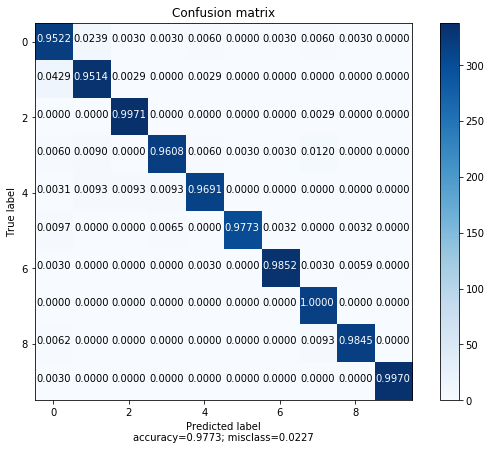

True Positive Rate: [0.95223881 0.95142857 0.99705015 0.96084337 0.9691358  0.97727273
 0.9852071  1.         0.98447205 0.99702381]
False Positive Rate: [0.0084317  0.00474576 0.00168862 0.00202156 0.00201613 0.00033422
 0.00101283 0.00368633 0.00134318 0.        ]

------



In [12]:
from sklearn.svm import SVC
linclf = SVC(kernel="linear")
print("Linear Classifier, original split:")
print(f"{train_set['target'].shape[0]} training examples")
run_experiment(linclf, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

## Neural Nets

0.9838999999999999
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       335
           1       0.97      0.96      0.97       350
           2       0.98      1.00      0.99       339
           3       0.99      0.98      0.99       332
           4       0.99      0.98      0.98       324
           5       0.99      0.98      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.99       322
           9       0.99      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



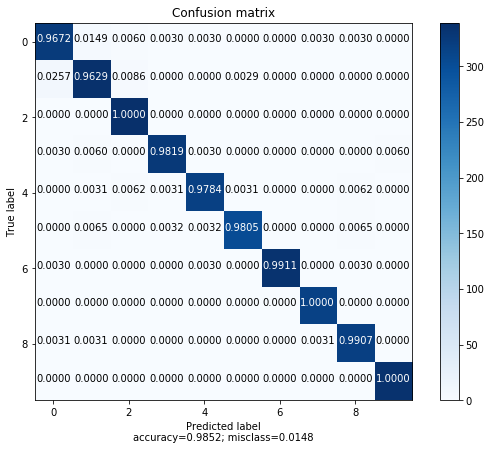

True Positive Rate: [0.96716418 0.96285714 1.         0.98192771 0.97839506 0.98051948
 0.99112426 1.         0.99068323 1.        ]
False Positive Rate: [0.00404722 0.00372881 0.00236407 0.00101078 0.00134409 0.00066845
 0.         0.00067024 0.00201478 0.00067476]



In [43]:
mlp_max = get_mlp()
cv = cross_validate(mlp_max, full_set.iloc[:,:-1], full_set['target'])
print(cv)
run_experiment(mlp_max, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])

# 5-7: Using different sized train/test sets instead of cross validation

Original split:
6700 training examples
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       335
           1       0.97      0.96      0.97       350
           2       0.98      1.00      0.99       339
           3       0.99      0.98      0.99       332
           4       0.99      0.98      0.98       324
           5       0.99      0.98      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.99       322
           9       0.99      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



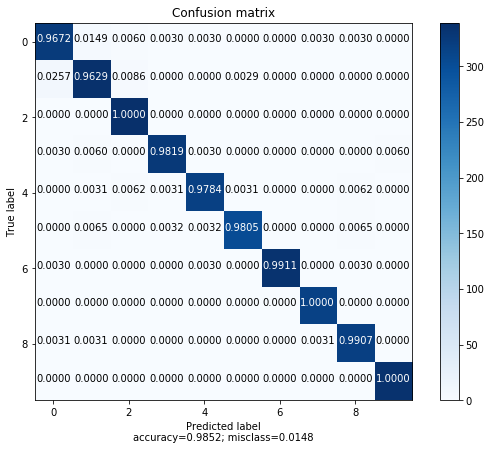

True Positive Rate: [0.96716418 0.96285714 1.         0.98192771 0.97839506 0.98051948
 0.99112426 1.         0.99068323 1.        ]
False Positive Rate: [0.00404722 0.00372881 0.00236407 0.00101078 0.00134409 0.00066845
 0.         0.00067024 0.00201478 0.00067476]

------

Reduced training set:
4720 training examples
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       520
           1       0.94      0.96      0.95       543
           2       0.99      1.00      0.99       530
           3       0.99      0.98      0.99       536
           4       0.98      0.96      0.97       544
           5       0.99      0.98      0.99       533
           6       1.00      0.99      1.00       519
           7       0.98      1.00      0.99       509
           8       0.97      0.99      0.98       515
           9       0.99      1.00      1.00       531

    accuracy                           0.98      5280
   macro avg       0.98      

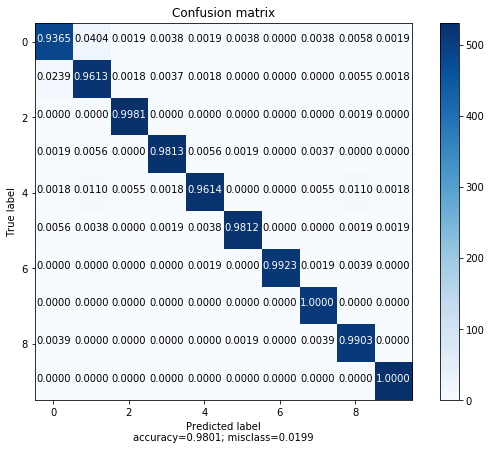

True Positive Rate: [0.93653846 0.96132597 0.99811321 0.98134328 0.96139706 0.98123827
 0.99229287 1.         0.99029126 1.        ]
False Positive Rate: [0.00420168 0.00675533 0.00105263 0.00126476 0.00168919 0.00084264
 0.         0.002096   0.00335782 0.00084228]

------

Smallest training set
2080 training examples
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       793
           1       0.88      0.94      0.91       795
           2       0.99      0.96      0.98       807
           3       0.97      0.97      0.97       808
           4       0.97      0.95      0.96       806
           5       0.99      0.97      0.98       787
           6       0.99      0.97      0.98       761
           7       0.95      1.00      0.97       796
           8       0.96      0.98      0.97       782
           9       0.99      0.99      0.99       785

    accuracy                           0.96      7920
   macro avg       0.96      

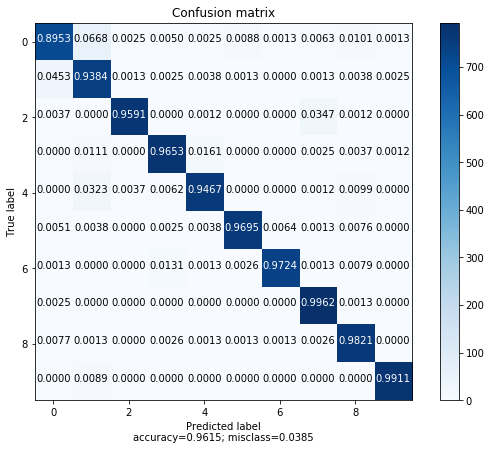

True Positive Rate: [0.89533417 0.93836478 0.95910781 0.96534653 0.94665012 0.96950445
 0.97240473 0.99623116 0.98209719 0.9910828 ]
False Positive Rate: [0.0072962  0.01389474 0.00084353 0.00351519 0.00337363 0.00154213
 0.00097779 0.00575519 0.00504343 0.00056062]

------



In [14]:
print("Original split:")
print(f"{train_set['target'].shape[0]} training examples")
mlp_max = get_mlp()
run_experiment(mlp_max, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")


print("Reduced training set:")
print(f"{train_set_30['target'].shape[0]} training examples")
mlp_mid = get_mlp()
run_experiment(mlp_mid, train_set_30.iloc[:,:-1], train_set_30['target'], test_set_30.iloc[:,:-1], test_set_30['target'])
print("------\n")


print("Smallest training set")
print(f"{train_set_70['target'].shape[0]} training examples")
mlp_small = get_mlp()
run_experiment(mlp_small, train_set_70.iloc[:,:-1], train_set_70['target'], test_set_70.iloc[:,:-1], test_set_70['target'])
print("------\n")


... So the results of the previous cell are a bit too good. Let's keep going with the training set reduction:

In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# half the remaining training data
def half_remaining_training_data(train_X, train_y, test_X, test_y):
    X_train_tiny, X_test_tiny_tmp, y_train_tiny, y_test_tiny_tmp = train_test_split(train_X, train_y, test_size=0.5, random_state=42)
    
    # Move the new test split into the existing test data
    X_test_tiny = pd.concat([X_test_tiny_tmp, test_X], axis=0)
    y_test_tiny = pd.concat([y_test_tiny_tmp, test_y], axis=0)
                             
    return X_train_tiny, X_test_tiny, y_train_tiny, y_test_tiny



In [16]:
X_train_90, X_test_90, y_train_90, y_test_90 = half_remaining_training_data(train_set_70.iloc[:,:-1], train_set_70['target'], test_set_70.iloc[:,:-1], test_set_70['target'])
X_train_95, X_test_95, y_train_95, y_test_95 = half_remaining_training_data(X_train_90, y_train_90, X_test_90, y_test_90)

10% training set
1040 training examples
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       896
           1       0.83      0.85      0.84       902
           2       0.98      0.94      0.96       896
           3       0.94      0.89      0.91       918
           4       0.92      0.92      0.92       904
           5       0.95      0.95      0.95       895
           6       0.99      0.93      0.96       877
           7       0.93      0.99      0.96       902
           8       0.83      0.95      0.89       883
           9       0.97      0.99      0.98       887

    accuracy                           0.92      8960
   macro avg       0.92      0.92      0.92      8960
weighted avg       0.92      0.92      0.92      8960



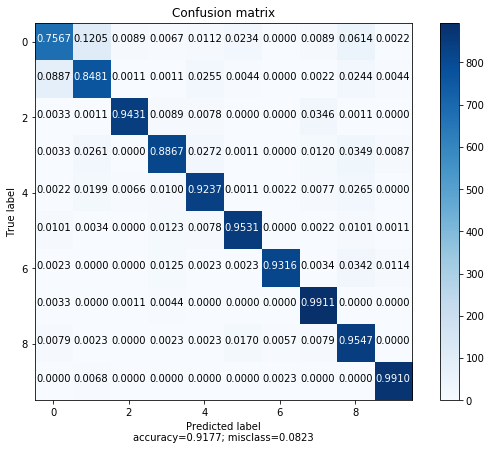

True Positive Rate: [0.75669643 0.8481153  0.94308036 0.88671024 0.92367257 0.95307263
 0.93158495 0.99113082 0.95469989 0.99098083]
False Positive Rate: [0.01351687 0.02010424 0.00198413 0.00646605 0.00943396 0.00545567
 0.00111345 0.00881112 0.02141884 0.00309674]

5% training set
520 training examples
              precision    recall  f1-score   support

           0       0.57      0.82      0.68       947
           1       0.77      0.62      0.69       949
           2       0.96      0.92      0.94       953
           3       0.96      0.84      0.90       959
           4       0.92      0.80      0.85       952
           5       0.93      0.90      0.91       952
           6       0.98      0.91      0.95       933
           7       0.87      1.00      0.93       939
           8       0.88      0.89      0.88       945
           9       0.97      0.97      0.97       951

    accuracy                           0.87      9480
   macro avg       0.88      0.87      0.87 

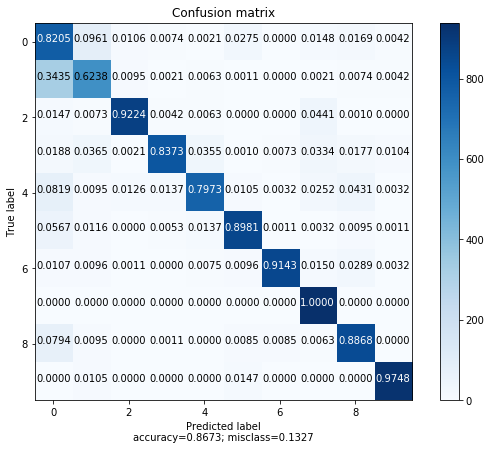

True Positive Rate: [0.82048574 0.62381454 0.92235047 0.83733055 0.79726891 0.89810924
 0.91425509 1.         0.88677249 0.97476341]
False Positive Rate: [0.06738544 0.02121674 0.00398733 0.00375543 0.00797373 0.00809099
 0.002223   0.01604028 0.01382542 0.00293118]



In [17]:
print("10% training set")
print(f"{y_train_90.shape[0]} training examples")
mlp_tiny = get_mlp()
run_experiment(mlp_tiny, X_train_90, y_train_90, X_test_90, y_test_90)

print("5% training set")
print(f"{y_train_95.shape[0]} training examples")
mlp_tinier = get_mlp()
run_experiment(mlp_tinier, X_train_95, y_train_95, X_test_95, y_test_95)


Keras model, original data split:
6700 training examples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 2,639,818
Trainable params: 2,639,818
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6700/6700 [==============================] - 2s 279us/step - loss: 1.0243 - accuracy: 0.6831
Epoch 2/10
6700/6700 [==============================] - 2s 257us/step - loss

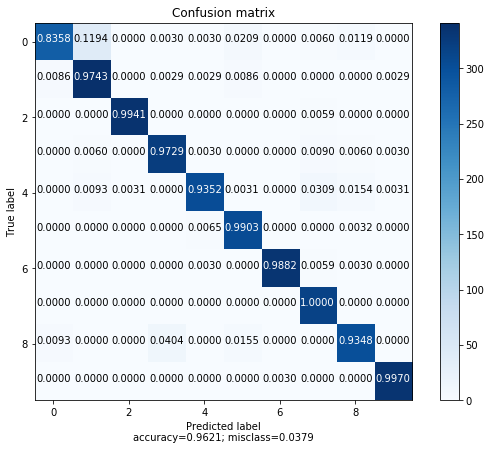

True Positive Rate: [0.8358209  0.97428571 0.99410029 0.97289157 0.93518519 0.99025974
 0.98816568 1.         0.93478261 0.99702381]
False Positive Rate: [0.00202361 0.01525424 0.00033772 0.00505391 0.00201613 0.00534759
 0.00033761 0.00636729 0.00436535 0.00101215]

------



In [18]:
print("Keras model, original data split:")
print(f"{train_set['target'].shape[0]} training examples")

run_experiment(kcls, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

## Experiments with CNNs

(6700, 2305)
(520, 2304)
(6700, 2304)
y_train_95.shape:  (520,)


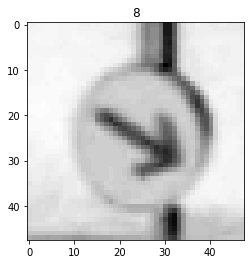

In [19]:
# Experiments in data reshaping to check techniques to be used in the CNN architecture
print(train_set.shape)
print(X_train_95.shape)
X_tmp = train_set.iloc[:,:-1]
print(X_tmp.shape)

reshaped_train = X_train_95.to_numpy().reshape(-1, 48, 48)
print("y_train_95.shape: ", y_train_95.shape)

plt.figure()
plt.imshow(reshaped_train[0], cmap='Greys')
plt.title(y_train_95.iloc[0])
plt.show()


In [20]:
def build_keras_cnn():
    '''
    A build function for a cnn that can be used by the keras skl classifier wrapper and therefore in our experimental setup.
    '''
    kernel_size = 3
    with tf.name_scope("convnet"):
        inputs = keras.Input(shape=(2304,), name='image')
        # reshape to [all examples=> -1, 48*48 image, greyscale=> 1 channel]
        reshape = keras.layers.Reshape(target_shape=(48, 48, 1))(inputs)


        layer_1 = keras.layers.Conv2D(filters=32, kernel_size=kernel_size, activation='relu')(reshape)
        pool_1 = keras.layers.MaxPooling2D()(layer_1)

        dense_block = keras.layers.Flatten()(pool_1)
        dense_block = keras.layers.Dense(256, activation='relu')(dense_block)
        dense_block = keras.layers.Dense(256, activation='relu')(dense_block)
        fin = keras.layers.Dense(64, activation='relu')(dense_block)

        # softmax_layer = keras.layers.Dense(10, activation='softmax')(model) # ignore softmax here, use SparseCategoricalCrossentropy below

        # compile the keras model
        model = keras.Model(inputs=inputs, outputs=fin, name='cnn')

        model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
        print(model.summary())

    return model

In [21]:


cnn_clf = KerasClassifier(build_fn=build_keras_cnn, epochs=10, batch_size=100, callbacks=[make_tensorboard_callback('cnn')])

CNN model, original data split:
6700 training examples
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2304)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4333824   
_________________________________________________________________
dense_1 

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.33      0.99      0.50       335
           1       0.96      0.97      0.96       350
           2       0.00      0.00      0.00       339
           3       1.00      0.99      0.99       332
           4       0.98      0.99      0.99       324
           5       0.99      0.99      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.98       322
           9       0.00      0.00      0.00       336

    accuracy                           0.79      3300
   macro avg       0.72      0.79      0.74      3300
weighted avg       0.72      0.79      0.74      3300



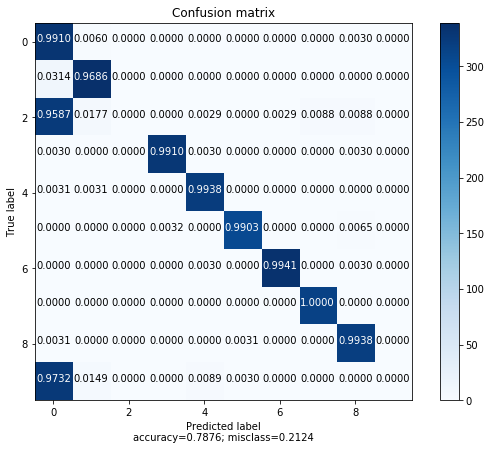

True Positive Rate: [0.99104478 0.96857143 0.         0.99096386 0.99382716 0.99025974
 0.99408284 1.         0.99378882 0.        ]
False Positive Rate: [0.22462057 0.00474576 0.         0.00033693 0.00201613 0.00066845
 0.00033761 0.00100536 0.00268637 0.        ]

------



In [22]:
print("CNN model, original data split:")
print(f"{train_set['target'].shape[0]} training examples")
run_experiment(cnn_clf, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

The junk architecture that I threw together as a test is slow but sometimes matches performance with the fully connected multi layer perceptron above.
Given that reduced training time is supposed to be an advantage of CNNs, this leaves some room for improvement.

# Visualize

In [23]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir tensorboard_logs --host 0.0.0.0


Reusing TensorBoard on port 6006 (pid 169), started 15:49:28 ago. (Use '!kill 169' to kill it.)

In [25]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6007: logdir tensorboard_logs_2layers (started 15:37:57 ago; pid 264)
  - port 6006: logdir tensorboard_logs (started 15:49:29 ago; pid 169)


In [26]:
# https://keras.io/visualization/
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot
def visualize(mlp2): 
    # mlp2 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
    #                     solver='sgd', verbose=10, tol=1e-4, random_state=1,
    #                     learning_rate_init=.1)

#     mlp2 = get_mlp()
#     run_experiment(mlp2, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])

    mlp2.fit(train_set.iloc[:,:-1], train_set['target'])
    print("Training set score: %f" % mlp2.score(train_set.iloc[:,:-1], train_set['target']))
    print("Test set score: %f" % mlp2.score(test_set.iloc[:,:-1], test_set['target']))

    fig, axes = plt.subplots(4, 4)
    # use global min / max to ensure all weights are shown on the same scale
    vmin, vmax = mlp2.coefs_[0].min(), mlp2.coefs_[0].max()
    for coef, ax in zip(mlp2.coefs_[0].T, axes.ravel()):
        ax.matshow(coef.reshape(48, 48), cmap=plt.cm.gray, vmin=.5 * vmin,
                   vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())

    plt.show()

# From here on out, will only use full data set since that gave the highest accuracy previously

## Point of comparison (same code from earlier): 

Original split:
6700 training examples
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       335
           1       0.97      0.96      0.97       350
           2       0.98      1.00      0.99       339
           3       0.99      0.98      0.99       332
           4       0.99      0.98      0.98       324
           5       0.99      0.98      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.99       322
           9       0.99      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



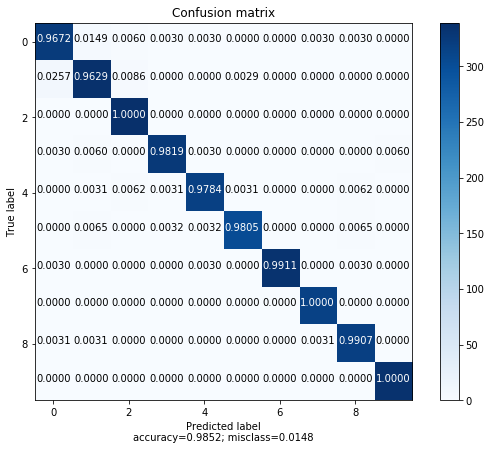

True Positive Rate: [0.96716418 0.96285714 1.         0.98192771 0.97839506 0.98051948
 0.99112426 1.         0.99068323 1.        ]
False Positive Rate: [0.00404722 0.00372881 0.00236407 0.00101078 0.00134409 0.00066845
 0.         0.00067024 0.00201478 0.00067476]

------



In [27]:
print("Original split:")
print(f"{train_set['target'].shape[0]} training examples")
mlp_max = get_mlp()
run_experiment(mlp_max, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")
# visualize(mlp_max)

# Adjusting learning rate:

## Adjusting the type of learning yielded no difference in accuracy value (always 98%)

In [28]:
# Learning rate can be constant, invscaling, adaptive. First and last are straight forward, but:
#Invscaling- constant except for when loss has NOT gone down for 2 epochs

######### Default init of 0.001 with different methods ########
# print("Learning Rate Constant: ")
# mlp = MLPClassifier(random_state=42, learning_rate='constant')
# run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
# print("------\n")

# print("Learning Rate Inverse Scaling: ")
# mlp = MLPClassifier(random_state=42, learning_rate='invscaling')
# run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
# print("------\n")

# print("Learning Rate Adaptive: ")
# mlp = MLPClassifier(random_state=42, learning_rate='adaptive')
# run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
# print("------\n")

Learning Rate Init = 0.0001: 


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       335
           1       0.97      0.98      0.97       350
           2       0.99      1.00      1.00       339
           3       0.99      0.98      0.99       332
           4       0.98      0.98      0.98       324
           5       1.00      0.98      0.99       308
           6       1.00      0.99      0.99       338
           7       1.00      1.00      1.00       316
           8       0.99      0.99      0.99       322
           9       1.00      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



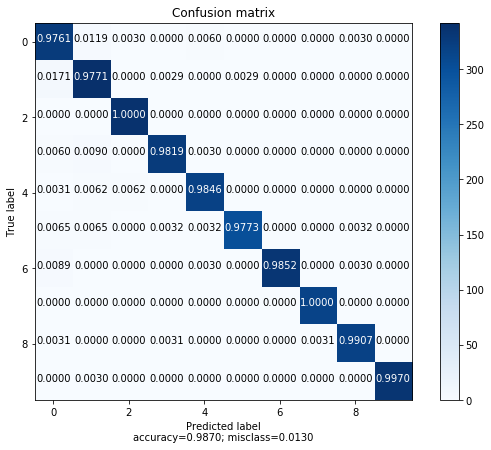

True Positive Rate: [0.9761194  0.97714286 1.         0.98192771 0.9845679  0.97727273
 0.9852071  1.         0.99068323 0.99702381]
False Positive Rate: [0.00505902 0.0040678  0.00101317 0.00101078 0.00168011 0.00033422
 0.         0.00033512 0.00100739 0.        ]

------



In [29]:
######## Different learning rate init values ########

#Increase learning rate to 0.5 (learning_rate_init)
# print("Learning Rate Init = 0.5: ")
# mlp = MLPClassifier(random_state=42, learning_rate_init=0.5)
# run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
# print("------\n")

#Decrease learning rate to 0.0001 (learning_rate_init)
print("Learning Rate Init = 0.0001: ")
mlp = MLPClassifier(random_state=42, learning_rate_init=0.0001)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

# Adjusting Epochs:

Epochs = 1000
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       335
           1       0.97      0.96      0.97       350
           2       0.98      1.00      0.99       339
           3       0.99      0.98      0.99       332
           4       0.99      0.98      0.98       324
           5       0.99      0.98      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.99       322
           9       0.99      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



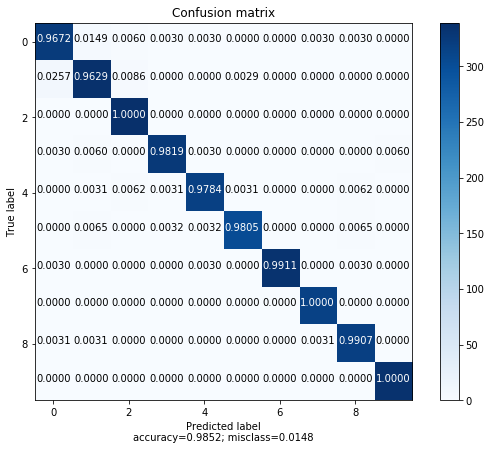

True Positive Rate: [0.96716418 0.96285714 1.         0.98192771 0.97839506 0.98051948
 0.99112426 1.         0.99068323 1.        ]
False Positive Rate: [0.00404722 0.00372881 0.00236407 0.00101078 0.00134409 0.00066845
 0.         0.00067024 0.00201478 0.00067476]

------

Epochs = 5: 


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.61      0.94      0.74       335
           1       0.97      0.50      0.66       350
           2       0.98      0.99      0.98       339
           3       0.98      0.98      0.98       332
           4       0.98      0.95      0.96       324
           5       0.98      0.93      0.96       308
           6       1.00      0.99      0.99       338
           7       0.98      1.00      0.99       316
           8       0.95      0.98      0.96       322
           9       0.99      1.00      1.00       336

    accuracy                           0.92      3300
   macro avg       0.94      0.93      0.92      3300
weighted avg       0.94      0.92      0.92      3300



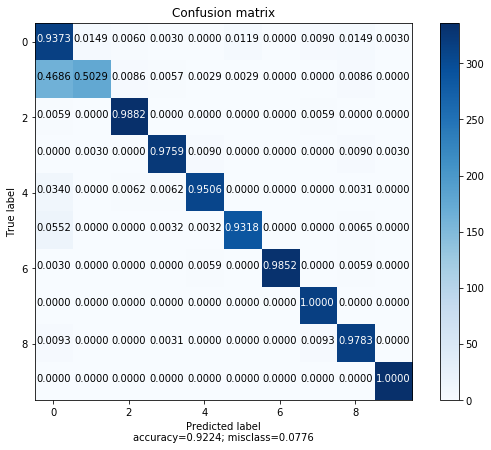

True Positive Rate: [0.93731343 0.50285714 0.98820059 0.97590361 0.95061728 0.93181818
 0.9852071  1.         0.97826087 1.        ]
False Positive Rate: [0.06677909 0.0020339  0.00236407 0.00235849 0.00235215 0.00167112
 0.         0.00268097 0.00537273 0.00067476]

------



In [30]:
# Epochs = max_iters in scikit

#Increase num epochs
print("Epochs = 1000")
mlp = MLPClassifier(random_state=42, max_iter=1000)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")
# visualize(mlp)

#Decrease num epochs
print("Epochs = 5: ")
mlp = MLPClassifier(random_state=42, max_iter=5)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

# Adjusting Momentum:

Momentum = 1.0: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       335
           1       0.97      0.96      0.97       350
           2       0.98      1.00      0.99       339
           3       0.99      0.98      0.99       332
           4       0.99      0.98      0.98       324
           5       0.99      0.98      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.99       322
           9       0.99      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



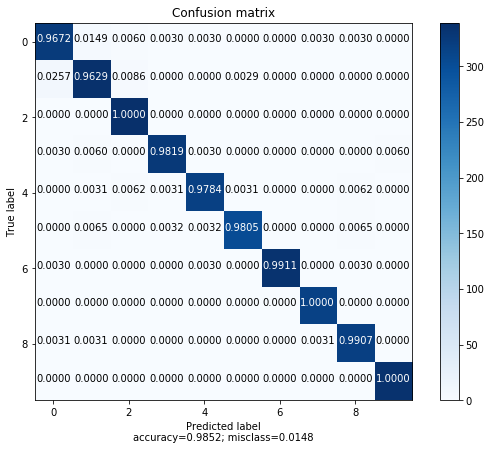

True Positive Rate: [0.96716418 0.96285714 1.         0.98192771 0.97839506 0.98051948
 0.99112426 1.         0.99068323 1.        ]
False Positive Rate: [0.00404722 0.00372881 0.00236407 0.00101078 0.00134409 0.00066845
 0.         0.00067024 0.00201478 0.00067476]

------

Momentum = 0.5: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       335
           1       0.97      0.96      0.97       350
           2       0.98      1.00      0.99       339
           3       0.99      0.98      0.99       332
           4       0.99      0.98      0.98       324
           5       0.99      0.98      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.99       322
           9       0.99      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
wei

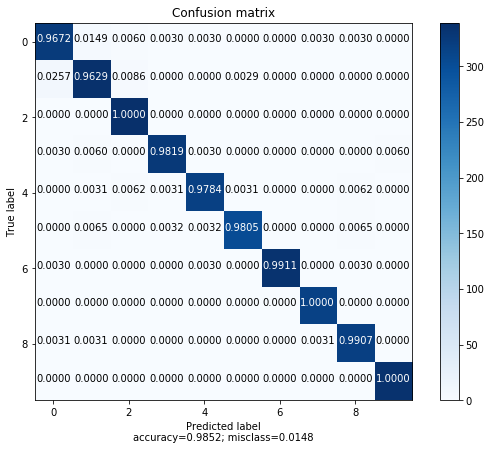

True Positive Rate: [0.96716418 0.96285714 1.         0.98192771 0.97839506 0.98051948
 0.99112426 1.         0.99068323 1.        ]
False Positive Rate: [0.00404722 0.00372881 0.00236407 0.00101078 0.00134409 0.00066845
 0.         0.00067024 0.00201478 0.00067476]

------

Momentum = 0.1: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       335
           1       0.97      0.96      0.97       350
           2       0.98      1.00      0.99       339
           3       0.99      0.98      0.99       332
           4       0.99      0.98      0.98       324
           5       0.99      0.98      0.99       308
           6       1.00      0.99      1.00       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.99       322
           9       0.99      1.00      1.00       336

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
wei

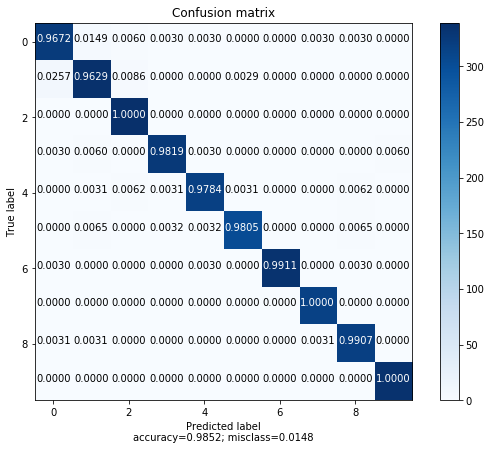

True Positive Rate: [0.96716418 0.96285714 1.         0.98192771 0.97839506 0.98051948
 0.99112426 1.         0.99068323 1.        ]
False Positive Rate: [0.00404722 0.00372881 0.00236407 0.00101078 0.00134409 0.00066845
 0.         0.00067024 0.00201478 0.00067476]

------



In [31]:
#Between 0 and 1, default = 0.9

print("Momentum = 1.0: ")
mlp = MLPClassifier(random_state=42, momentum=1.0)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

print("Momentum = 0.5: ")
mlp = MLPClassifier(random_state=42, momentum=0.5)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

print("Momentum = 0.1: ")
mlp = MLPClassifier(random_state=42, momentum=0.1)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

# Adjusting Validation Threshold:

Validation Threshold = 0.1: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       335
           1       0.95      0.96      0.96       350
           2       0.99      1.00      1.00       339
           3       0.99      0.97      0.98       332
           4       0.96      0.98      0.97       324
           5       0.99      0.96      0.98       308
           6       1.00      0.99      0.99       338
           7       0.99      1.00      1.00       316
           8       0.98      0.99      0.98       322
           9       1.00      1.00      1.00       336

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



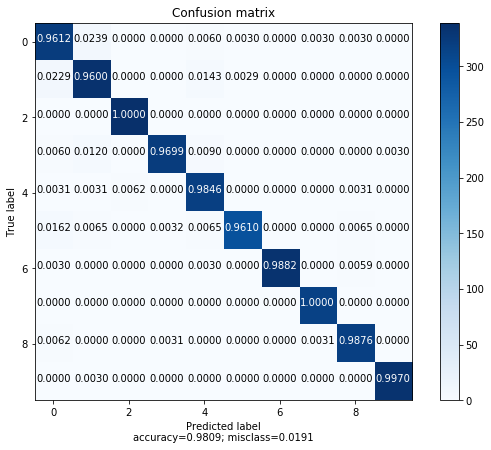

True Positive Rate: [0.96119403 0.96       1.         0.96987952 0.9845679  0.96103896
 0.98816568 1.         0.98757764 0.99702381]
False Positive Rate: [0.00640809 0.00542373 0.00067545 0.00067385 0.00436828 0.00066845
 0.         0.00067024 0.00201478 0.00033738]

------

Validation Threshold = 0.5: 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       335
           1       0.92      0.96      0.94       350
           2       0.99      0.99      0.99       339
           3       0.98      0.98      0.98       332
           4       0.98      0.98      0.98       324
           5       0.99      0.96      0.98       308
           6       1.00      0.98      0.99       338
           7       0.97      1.00      0.99       316
           8       0.98      0.99      0.98       322
           9       1.00      1.00      1.00       336

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98  

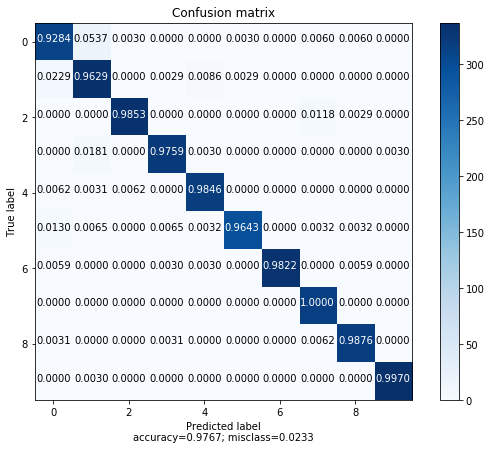

True Positive Rate: [0.92835821 0.96285714 0.98525074 0.97590361 0.9845679  0.96428571
 0.98224852 1.         0.98757764 0.99702381]
False Positive Rate: [0.00573356 0.00949153 0.00101317 0.00168464 0.00201613 0.00066845
 0.         0.00301609 0.00201478 0.00033738]

------

Validation Threshold = 0.9: 
              precision    recall  f1-score   support

           0       0.84      0.70      0.77       335
           1       0.78      0.89      0.83       350
           2       0.94      0.91      0.93       339
           3       0.98      0.89      0.94       332
           4       0.93      0.89      0.91       324
           5       0.94      0.90      0.92       308
           6       0.98      0.93      0.95       338
           7       0.82      0.97      0.89       316
           8       0.88      0.98      0.93       322
           9       0.98      0.96      0.97       336

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90  

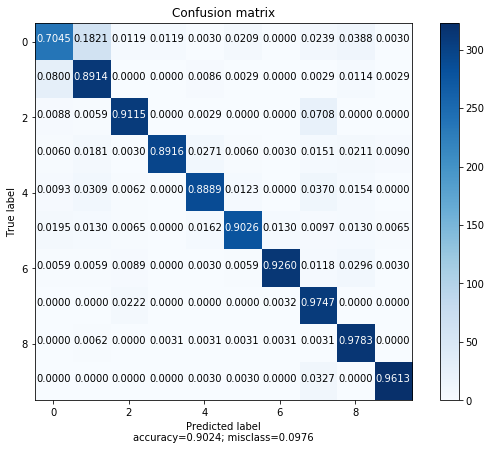

True Positive Rate: [0.70447761 0.89142857 0.91150442 0.89156627 0.88888889 0.9025974
 0.9260355  0.97468354 0.97826087 0.96130952]
False Positive Rate: [0.0148398  0.02949153 0.00641675 0.00168464 0.00739247 0.00601604
 0.00236327 0.02312332 0.01443922 0.00269906]

------



In [32]:
#Only used if early_stopping = True (which default is false)
#Must be between 0 and 1

print("Validation Threshold = 0.1: ")
mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

print("Validation Threshold = 0.5: ")
mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.5)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")

print("Validation Threshold = 0.9: ")
mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.9)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")


# print("Validation Threshold = 0.6: ")
# mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.6)
# run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
# print("------\n")


# print("Validation Threshold = 0.75: ")
# mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.75)
# run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
# print("------\n")

# Adjusting layers/nodes/connections (via Keras):

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2304)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10250     
Total params: 2,370,570
Trainable params: 2,370,570
Non-trainable params: 0
_________________________________________________________________
None
Train on 6700 samples
Epoch 1/10
6700/6700 [==============================] - 2s 235us/sample - loss: 1.1774 - accuracy: 0.7554
Epoch 2/10
6700/6700 [==============================] - 1s 163us/sample - loss: 0.3215 - accuracy: 0.9106
Epoch 3/10
6700/6700 [==============================] - 1s 166us/sample - loss: 0.1850 - accuracy: 0.9406
Epoch 4/10
6700/6700 [================

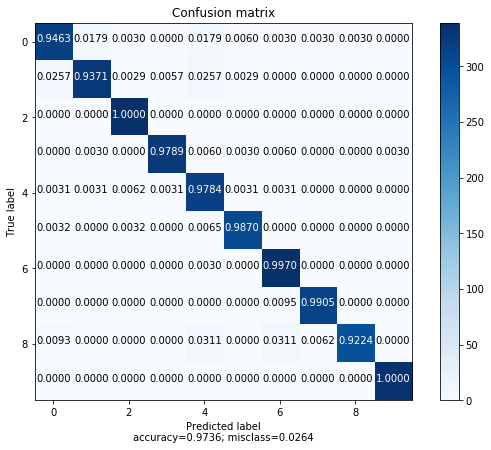

True Positive Rate: [0.94626866 0.93714286 1.         0.97891566 0.97839506 0.98701299
 0.99704142 0.99050633 0.92236025 1.        ]
False Positive Rate: [0.00472175 0.00271186 0.00168862 0.00101078 0.01008065 0.00167112
 0.00573937 0.00100536 0.0003358  0.00033738]



In [33]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/
#96% with orriginal keras model
#Baseline was 97% accuracy

def two_layer_keras():
    with tf.name_scope("two_layer_keras"):

        inputs = keras.Input(shape=(2304,), name='image')

        model = keras.layers.Dense(1024, activation='relu')(inputs)

    #     model.add(Dense(256, activation='relu'))
    #     model.add(Dense(64, activation='relu'))

        softmax = keras.layers.Dense(10, activation='softmax')(model)

        # compile the keras model
        model = keras.Model(inputs=inputs, outputs=softmax, name='cnn')
        model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


    print(model.summary())
    return model

# fit the keras model on the dataset
# model.fit(X_train, y_train, epochs=10, batch_size=100)

# evaluate the keras model
# loss, accuracy = model.evaluate(X_test, y_test)

kcls_2layers = KerasClassifier(build_fn=two_layer_keras, epochs=10, batch_size=100, callbacks=[make_tensorboard_callback("two_layer_keras")])
run_experiment(kcls_2layers, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])

#Note, if you try running this example in an IPython or Jupyter notebook you may get an error.
#The reason is the output progress bars during training. 
#You can easily turn these off by setting verbose=0 in fit() and evaluate() calls



Model: "four_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2304)]            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                10250     
Total params: 4,469,770
Trainable params: 4,469,770
Non-trainable params: 0
_________________________________________________________________
None
Train on 6700 samples
Epoch 1/10
6700/6700 [==============================] - 3s 410us/sample - loss: 1.051

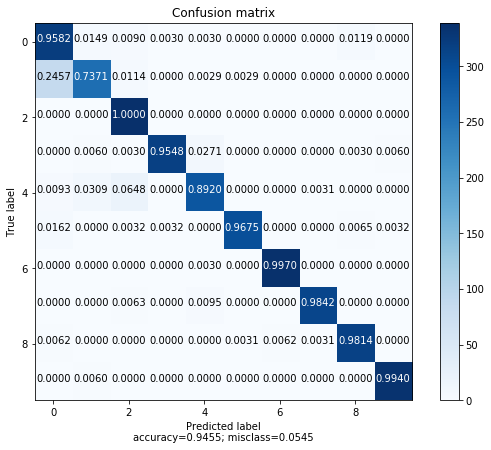

True Positive Rate: [0.95820896 0.73714286 1.         0.95481928 0.89197531 0.96753247
 0.99704142 0.98417722 0.98136646 0.99404762]
False Positive Rate: [0.03237774 0.00644068 0.01080716 0.00067385 0.00504032 0.00066845
 0.00067522 0.00067024 0.00235057 0.00101215]



In [34]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/
#96% with orriginal keras model
#Baseline was 97% accuracy
def same_layer_keras():
    with tf.name_scope("four_layer_keras"):

        inputs = keras.Input(shape=(2304,), name='image')
        model = keras.layers.Dense(1024, activation='relu')(inputs)
        model = keras.layers.Dense(1024, activation='relu')(model)
        model = keras.layers.Dense(1024, activation='relu')(model)
        softmax = keras.layers.Dense(10, activation='softmax')(model)

        # compile the keras model
        model = keras.Model(inputs=inputs, outputs=softmax, name='four_layer')
        model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    return model

kcls_same = KerasClassifier(build_fn=same_layer_keras, epochs=10, batch_size=100, callbacks=[make_tensorboard_callback("same_layer_keras")])
run_experiment(kcls_same, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])

Model: "six_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2304)]            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_10 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                65

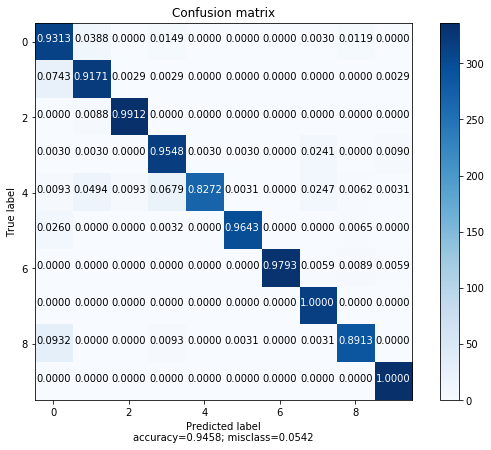

True Positive Rate: [0.93134328 0.91714286 0.99115044 0.95481928 0.82716049 0.96428571
 0.97928994 1.         0.89130435 1.        ]
False Positive Rate: [0.02293423 0.01118644 0.00135089 0.01078167 0.00033602 0.00100267
 0.         0.00670241 0.00369375 0.00236167]



In [35]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/
#96% with orriginal keras model
#Baseline was 97% accuracy
def six_layer_keras():
    with tf.name_scope("six_layer_keras"):

        inputs = keras.Input(shape=(2304,), name='image')
        model = keras.layers.Dense(1024, activation='relu')(inputs)
        model = keras.layers.Dense(500, activation='relu')(model)
        model = keras.layers.Dense(256, activation='relu')(model)
        model = keras.layers.Dense(100, activation='relu')(model)
        model = keras.layers.Dense(64, activation='relu')(model)
        softmax = keras.layers.Dense(10, activation='softmax')(model)

        # compile the keras model
        model = keras.Model(inputs=inputs, outputs=softmax, name='six_layer')
        model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    return model

kcls_6layers = KerasClassifier(build_fn=six_layer_keras, epochs=10, batch_size=100, callbacks=[make_tensorboard_callback("six_layer_keras")])
run_experiment(kcls_6layers, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10250     
Total params: 2,370,570
Trainable params: 2,370,570
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
6700/6700 [==============================] - 2s 243us/step - loss: 0.9340 - accuracy: 0.7572
Epoch 2/10
6700/6700 [==============================] - 2s 233us/step - loss: 0.2059 - accuracy: 0.9406
Epoch 3/10
6700/6700 [==============================] - 2s 235us/step - loss: 0.1448 - accuracy: 0.9551
Epoch 4/10
6700/6700 [==============================] - 2s 243us/step - loss: 0.1386 - accuracy: 0.9585
Epoch 5/10
6700/6700 [==============================] - 2s 236us/step - loss: 0.1086 

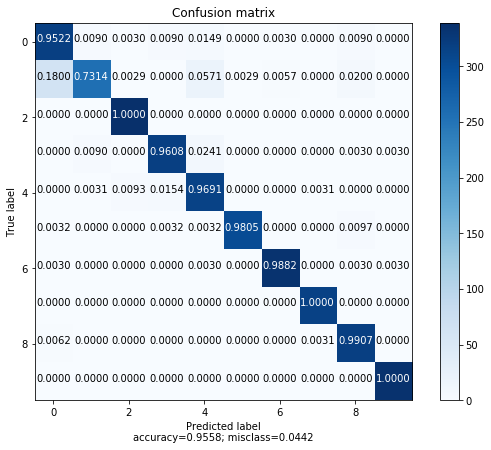

True Positive Rate: [0.95223881 0.73142857 1.         0.96084337 0.9691358  0.98051948
 0.98816568 1.         0.99068323 1.        ]
False Positive Rate: [0.02259696 0.00237288 0.00168862 0.00303235 0.01176075 0.00033422
 0.00101283 0.00067024 0.00503694 0.00067476]



In [36]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/
#96% with orriginal keras model
#Baseline was 97% accuracy
def tanh_softmax_keras():
    model = Sequential()
    model.add(Dense(1024, input_dim=2304, activation='tanh'))
#     model.add(Dense(1024, input_dim=2304, activation='softmax'))
    model.add(Dense(10, activation='softmax'))
    print(model.summary())

    # compile the keras model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

kcls_activ = KerasClassifier(build_fn=tanh_softmax_keras, epochs=10, batch_size=100)
run_experiment(kcls_activ, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])


# Maximizing all parameters:

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       335
           1       0.94      0.92      0.93       350
           2       0.99      1.00      0.99       339
           3       0.99      0.97      0.98       332
           4       0.98      0.97      0.97       324
           5       0.98      0.97      0.97       308
           6       1.00      0.99      0.99       338
           7       0.99      1.00      0.99       316
           8       0.98      0.98      0.98       322
           9       1.00      0.99      1.00       336

    accuracy                           0.97      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.97      0.97      0.97      3300



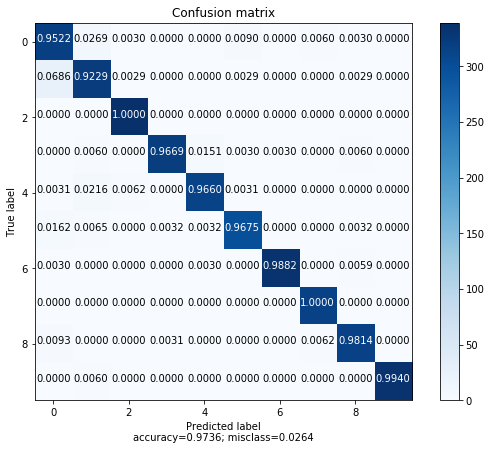

True Positive Rate: [0.95223881 0.92285714 1.         0.96686747 0.96604938 0.96753247
 0.98816568 1.         0.98136646 0.99404762]
False Positive Rate: [0.01146712 0.00745763 0.00135089 0.00067385 0.00235215 0.00200535
 0.00033761 0.00134048 0.00235057 0.        ]

------



In [37]:
mlp = MLPClassifier(random_state=42, learning_rate_init=0.0001, max_iter=1000, early_stopping=True, validation_fraction=0.1)
run_experiment(mlp, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
print("------\n")
# visualize(mlp)

In [38]:
#Can only work with Keras
# history = kcls.fit(train_set.iloc[:,:-1], train_set['target'], validation_split=0.25, epochs=10, batch_size=100)

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(historny.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Best performing tests visualization

In [39]:
tensorboard_callback2 = keras.callbacks.TensorBoard(
    log_dir='tensorboard_logs_2layers', histogram_freq=1, write_graph=True, write_images=True
)

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2304)]            0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2360320   
_________________________________________________________________
dense_16 (Dense)             (None, 10)                10250     
Total params: 2,370,570
Trainable params: 2,370,570
Non-trainable params: 0
_________________________________________________________________
None
Train on 6700 samples
Epoch 1/10
6700/6700 [==============================] - 2s 249us/sample - loss: 1.3300 - accuracy: 0.7309
Epoch 2/10
6700/6700 [==============================] - 1s 158us/sample - loss: 0.2643 - accuracy: 0.9260
Epoch 3/10
6700/6700 [==============================] - 1s 178us/sample - loss: 0.2047 - accuracy: 0.9367
Epoch 4/10
6700/6700 [================

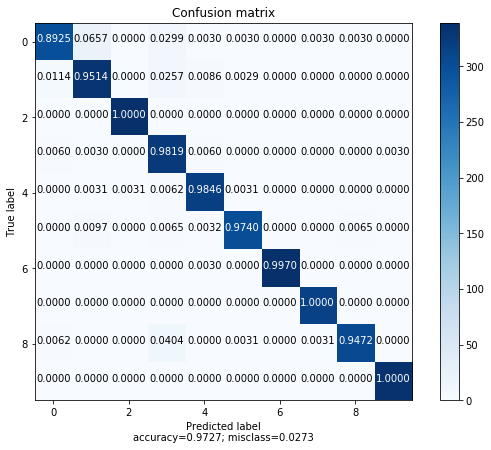

True Positive Rate: [0.89253731 0.95142857 1.         0.98192771 0.9845679  0.97402597
 0.99704142 1.         0.94720497 1.        ]
False Positive Rate: [0.00269815 0.00915254 0.00033772 0.01212938 0.00268817 0.0013369
 0.         0.00067024 0.00100739 0.00033738]

Model: "four_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2304)]            0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              2360320   
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_20 (Dense)             (None, 10)              

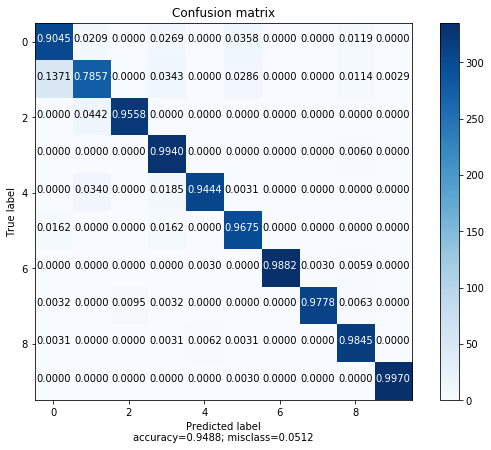

True Positive Rate: [0.90447761 0.78571429 0.95575221 0.9939759  0.94444444 0.96753247
 0.98816568 0.9778481  0.98447205 0.99702381]
False Positive Rate: [0.01854975 0.01118644 0.00101317 0.01145553 0.00100806 0.00835561
 0.         0.00033512 0.00470114 0.00033738]

Model: "six_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2304)]            0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              2360320   
_________________________________________________________________
dense_22 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_23 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_24 (Dense)             (None, 100)             

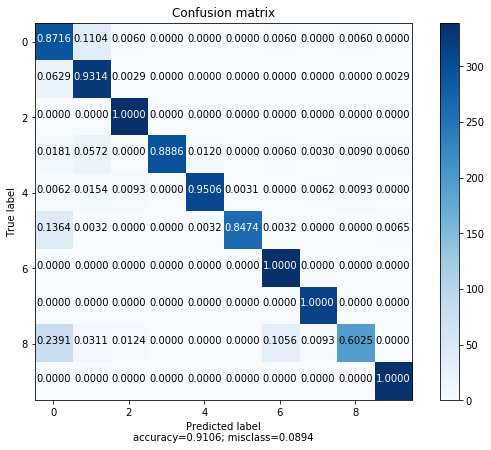

True Positive Rate: [0.87164179 0.93142857 1.         0.88855422 0.95061728 0.8474026
 1.         1.         0.60248447 1.        ]
False Positive Rate: [0.05025295 0.02440678 0.00337724 0.         0.00168011 0.00033422
 0.01316678 0.00201072 0.00268637 0.00168691]



In [40]:
# cnn_clf = KerasClassifier(build_fn=build_keras_cnn, epochs=10, batch_size=100, callbacks=[tensorboard_callback])

# mlp_validation = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1, callbacks=[tensorboard_callback])
kcls_2layer = KerasClassifier(build_fn=two_layer_keras, epochs=10, batch_size=100, callbacks=[tensorboard_callback2])
kcls_1024 = KerasClassifier(build_fn=same_layer_keras, epochs=10, batch_size=100, callbacks=[tensorboard_callback2])
kcls_6layer = KerasClassifier(build_fn=six_layer_keras, epochs=10, batch_size=100, callbacks=[tensorboard_callback2])

run_experiment(kcls_2layer, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
run_experiment(kcls_1024, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])
run_experiment(kcls_6layer, train_set.iloc[:,:-1], train_set['target'], test_set.iloc[:,:-1], test_set['target'])


In [41]:
%reload_ext tensorboard

In [42]:
%tensorboard --logdir tensorboard_logs_2layers --host 0.0.0.0

Reusing TensorBoard on port 6007 (pid 264), started 15:44:20 ago. (Use '!kill 264' to kill it.)